In [1]:
import pandas as pd
from os import listdir
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

# Ignore Warnings
import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# TRAINSET_SIZE = 100
# EXPERIMENT_PATH = '../paper_evaluation/experiments/trainsetsize/' + str(TRAINSET_SIZE) + '/'
# DISSIMILARITY_MATRICES_PATH = EXPERIMENT_PATH + 'dissmat/'

EXPERIMENT_PATH = '../paper_evaluation/experiments_ph/trainsetsize/100/'
DISSIMILARITY_MATRICES_PATH = EXPERIMENT_PATH + 'dissmat/'

max_cluster_size = 1  # Parameter to control the maximum size of clusters to merge
dissimilarity_matrices = {}

for filename in sorted(listdir(DISSIMILARITY_MATRICES_PATH)):
    dissimilarity_matrices[filename.split("_")[0]] = pd.read_pickle(DISSIMILARITY_MATRICES_PATH + filename)

## Hierarchical Clustering

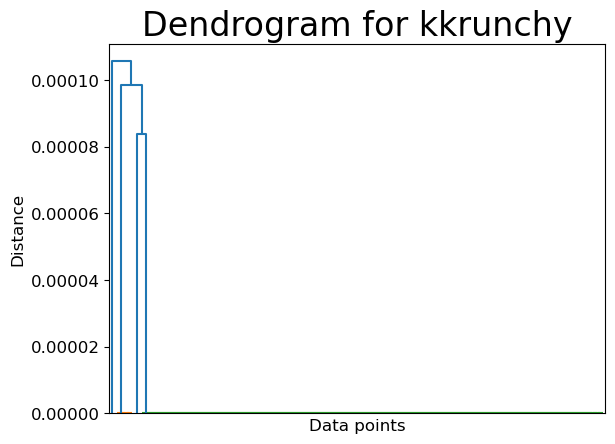

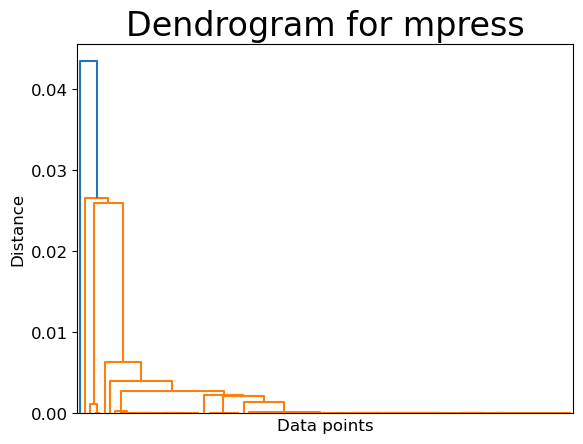

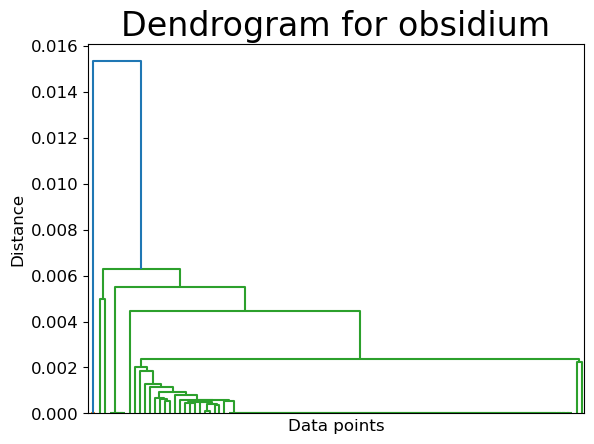

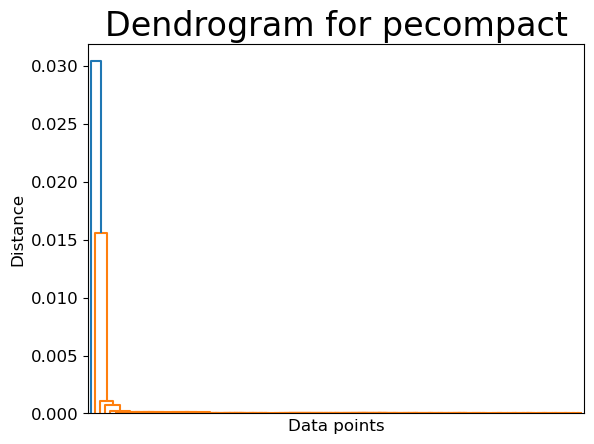

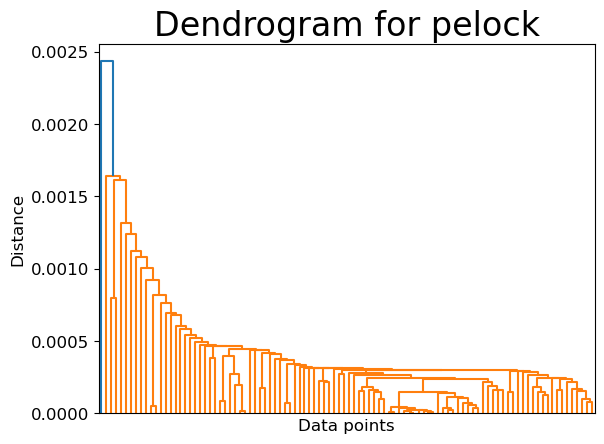

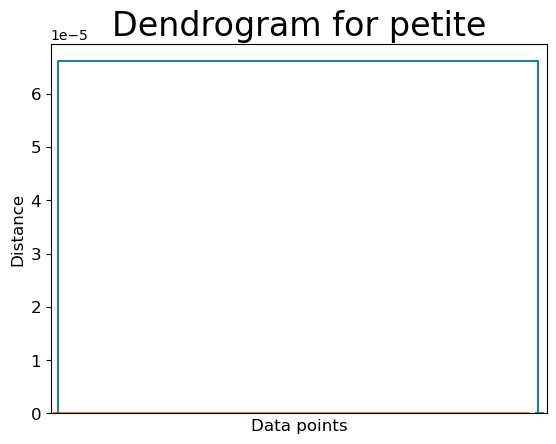

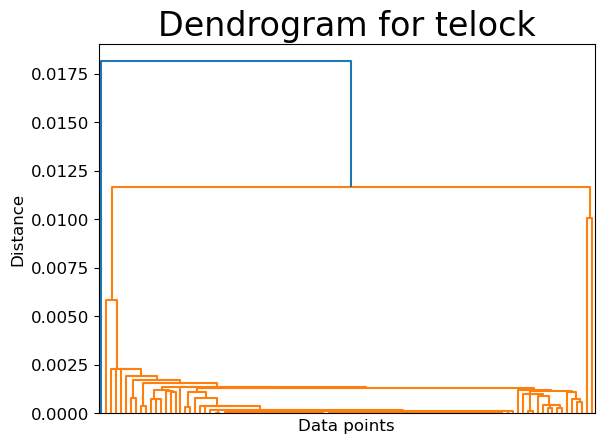

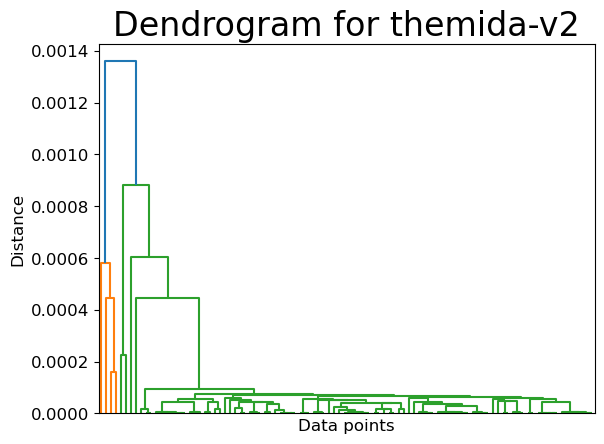

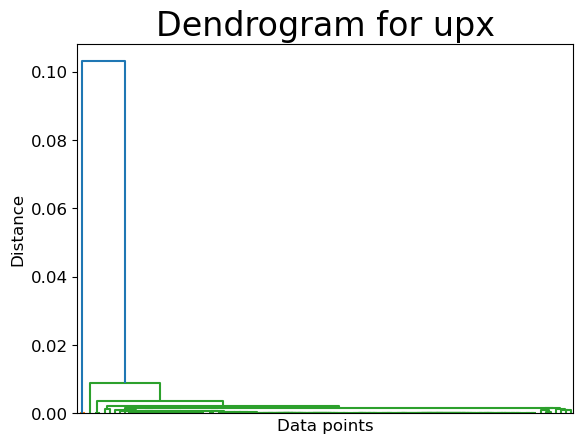

In [2]:
Z_dict = {}

for packer in dissimilarity_matrices:
    dm = ssd.squareform(dissimilarity_matrices[packer])
    Z = linkage(dm, 'single')
    Z_dict[packer] = Z

    dn = dendrogram(Z)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.title("Dendrogram for " + packer, fontsize=24)
    plt.ylabel("Distance", fontsize=12)
    plt.xlabel("Data points", fontsize=12)
    #plt.savefig("Dendrogram.png")
    plt.xticks([])
    plt.show()

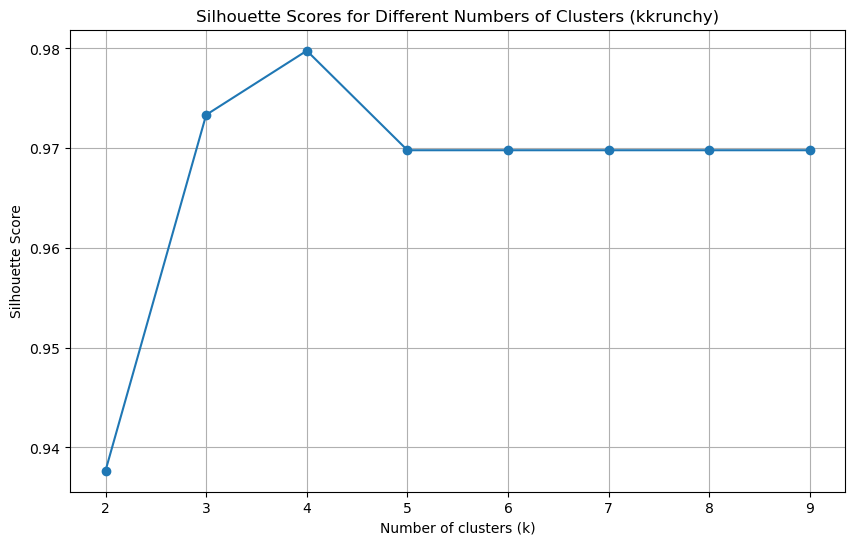

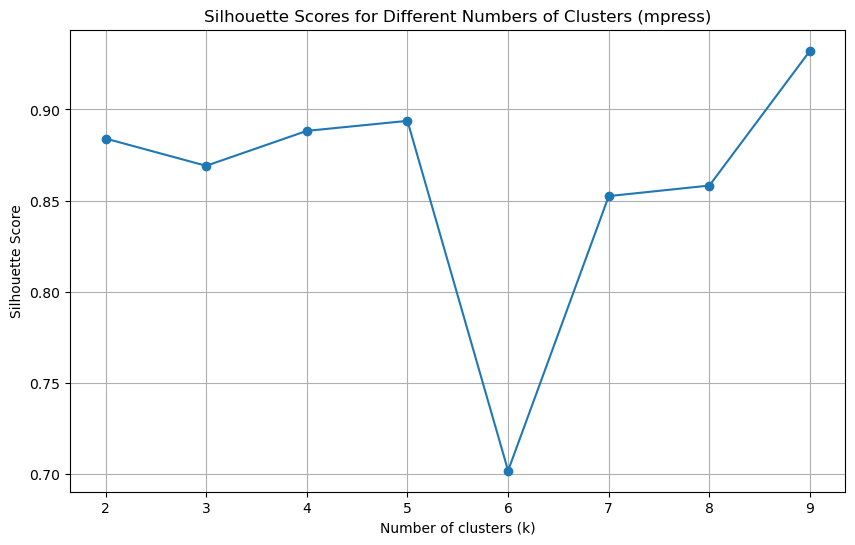

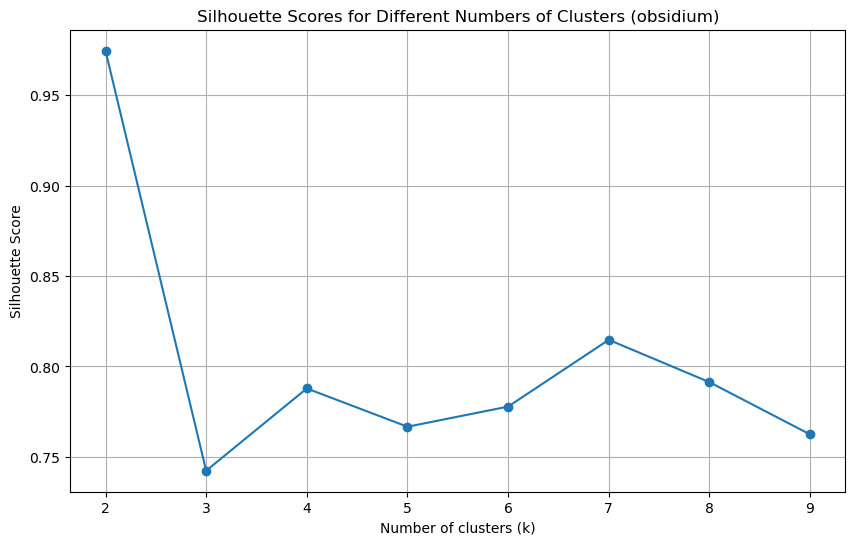

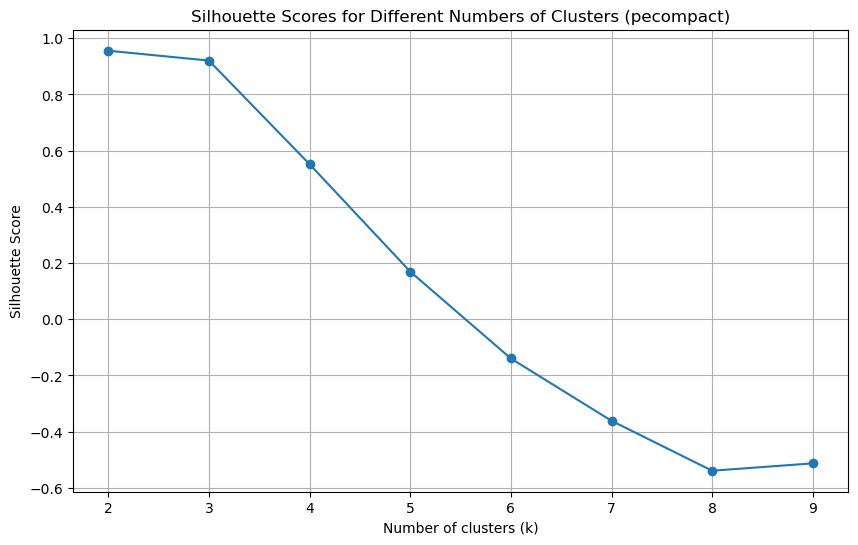

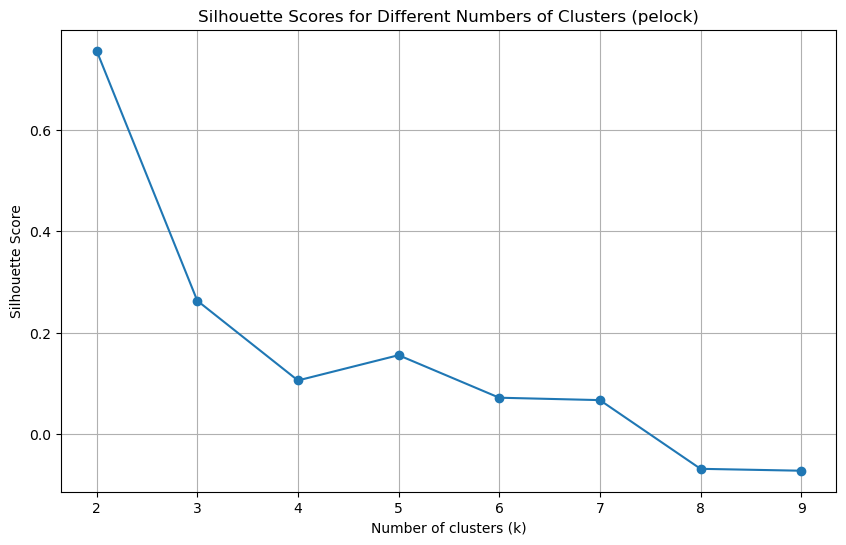

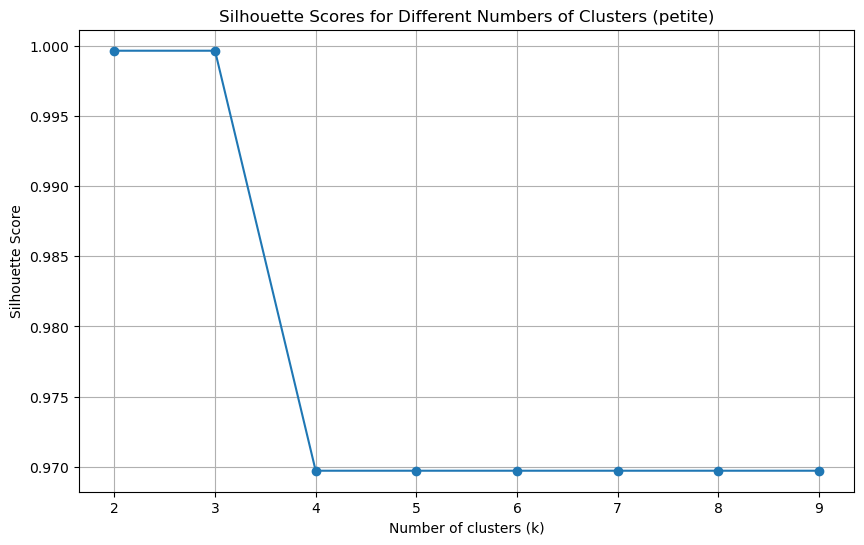

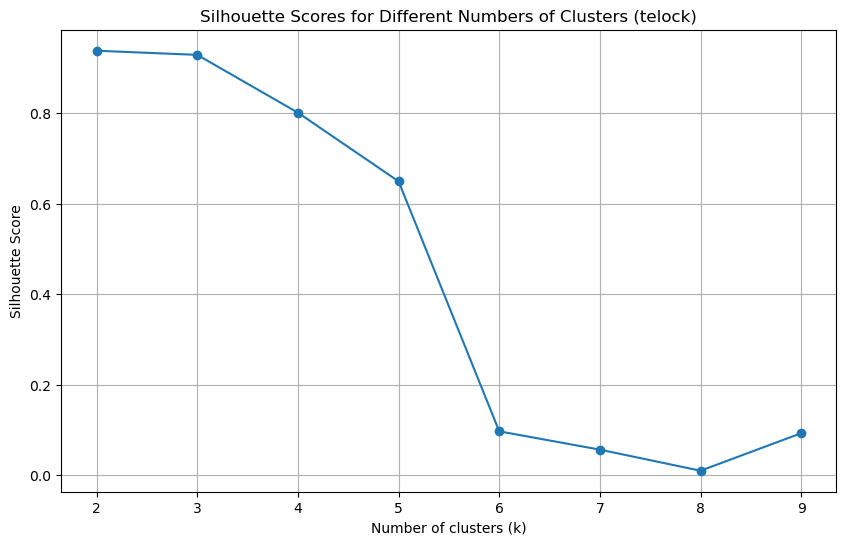

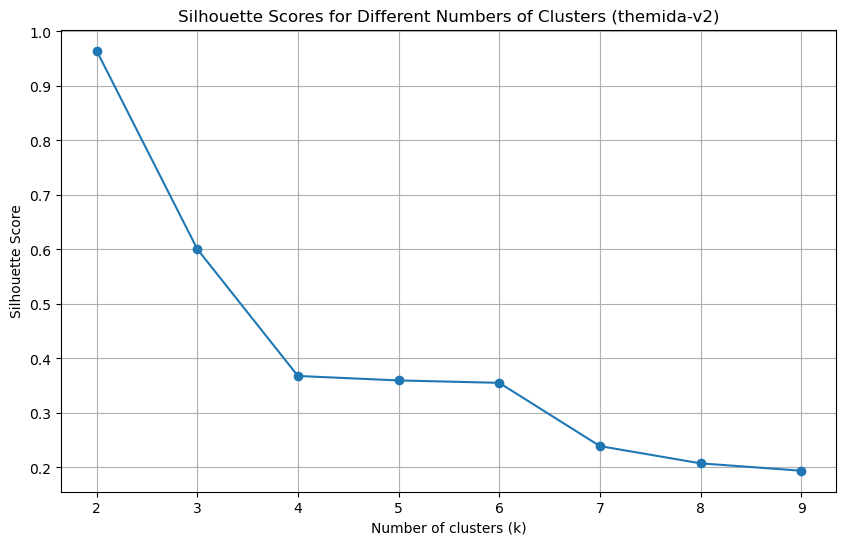

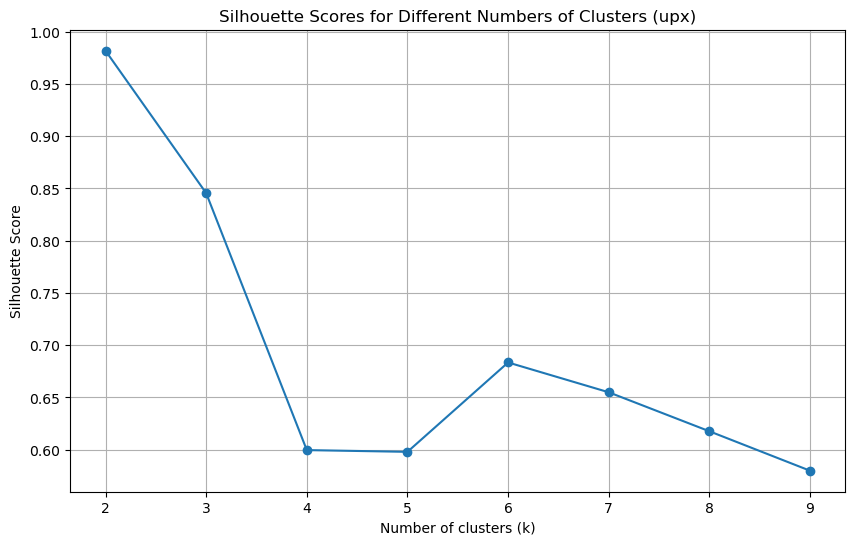

In [3]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
import numpy as np

max_k = 10
hierarchical_silhouette_scores = []
best_ks = {}

for packer in Z_dict:
    Z = Z_dict[packer]
    hierarchical_silhouette_s = []
    for k in range(2, max_k):
        hierarchical_l = fcluster(Z, k, criterion='maxclust')
        if len(set(hierarchical_l)) == 1:
            hierarchical_silhouette_s.append(0)
            continue
        score = silhouette_score(dissimilarity_matrices[packer], hierarchical_l, metric='precomputed')
        hierarchical_silhouette_s.append(score)
    best_ks[packer] = np.argmax(hierarchical_silhouette_s) + 2
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k), hierarchical_silhouette_s, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Numbers of Clusters ({packer})')
    plt.grid(True)
    plt.show()

In [4]:
from collections import defaultdict
hierarchical_labels_by_packer = {}
packer_labels = np.array([], dtype='str')

for packer in Z_dict:
    Z = Z_dict[packer]
    k = best_ks[packer]
    clustering = fcluster(Z, k, criterion='maxclust')
    hierarchical_labels_by_packer[packer] = clustering

    packer_labels = np.concatenate((packer_labels, np.full(len(clustering), packer)))

hierarchical_labels_by_packer

{'kkrunchy': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
 'mpress': array([4, 4, 4, 2, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 2,
        4, 4, 4, 3, 4, 4, 2, 4, 4, 4, 2, 4, 2, 2, 4, 4, 4, 2, 4, 2, 4, 6,
        4, 4, 3, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4, 3, 4, 4, 2, 4, 3, 2, 4, 4,
        1, 4, 9, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 3, 4, 1, 4, 4, 8, 4, 4, 5,
        4, 4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 2], dtype=int32),
 'obsidium': array([2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2,

In [5]:
done = False
mod = 0
old_mod = 0

while not done:

    for packer in hierarchical_labels_by_packer:

        for i in range(1, max(hierarchical_labels_by_packer[packer]) + 1):
            cluster_indexes = [j for j, x in enumerate(hierarchical_labels_by_packer[packer]) if x == i]
            
            # Check if the cluster size is within the specified limit
            if 1 <= len(cluster_indexes) <= max_cluster_size:
                min_cluster = 0
                min_distance = float('inf')  # Initialize with infinity
                print(f"Processing Cluster {i} in {packer}")

                for sample_index in cluster_indexes:
                    for j in range(1, max(hierarchical_labels_by_packer[packer]) + 1):
                        if i != j:  # Skip the same cluster
                            other_cluster_indexes = [k for k, x in enumerate(hierarchical_labels_by_packer[packer]) if x == j]
                            # Scale sample index and other cluster indexes to the range of the dissimilarity matrix
                            distance = dissimilarity_matrices[packer].iloc[sample_index, other_cluster_indexes].min()
                            if distance < min_distance:
                                min_distance = distance
                                min_cluster = j
                    
                    print(f"Sample {sample_index} from Cluster {i} moved to Cluster {min_cluster}")
                    mod += 1
                    hierarchical_labels_by_packer[packer][sample_index] = min_cluster

                # Adjust cluster numbers for subsequent clusters
                for k in range(len(hierarchical_labels_by_packer[packer])):
                    if hierarchical_labels_by_packer[packer][k] > i:
                        hierarchical_labels_by_packer[packer][k] -= 1
    
    if mod == old_mod:
        done = True
    else:
        old_mod = mod


Processing Cluster 3 in kkrunchy
Sample 29 from Cluster 3 moved to Cluster 2
Processing Cluster 5 in mpress
Sample 87 from Cluster 5 moved to Cluster 3
Processing Cluster 6 in mpress
Sample 6 from Cluster 6 moved to Cluster 4
Processing Cluster 7 in mpress
Sample 68 from Cluster 7 moved to Cluster 3
Processing Cluster 2 in pecompact
Sample 59 from Cluster 2 moved to Cluster 1
Processing Cluster 2 in pelock
Sample 91 from Cluster 2 moved to Cluster 1
Processing Cluster 2 in telock
Sample 37 from Cluster 2 moved to Cluster 1
Processing Cluster 3 in kkrunchy
Sample 55 from Cluster 3 moved to Cluster 2
Processing Cluster 5 in mpress
Sample 43 from Cluster 5 moved to Cluster 3
Processing Cluster 5 in mpress
Sample 84 from Cluster 5 moved to Cluster 3


In [6]:
import numpy as np

def find_medoids(dissimilarity_matrices, cluster_labels_by_packer):
    medoids = defaultdict(lambda: [])
    for packer in hierarchical_labels_by_packer:
        for cluster_id in np.unique(cluster_labels_by_packer[packer]):
            # Extract the indices of points within this cluster
            indices = np.where(cluster_labels_by_packer[packer] == cluster_id)[0]
            # Extract the submatrix of dissimilarities corresponding to these points
            cluster_dissimilarity_matrix = dissimilarity_matrices[packer].iloc[indices, indices]

            # Find the medoid (point with the smallest total distance to all others in the cluster)
            medoid_index = indices[np.argmin(cluster_dissimilarity_matrix.sum(axis=1))]
            medoids[packer].append(medoid_index)
    
    return medoids

hierarchical_medoids_by_packer = find_medoids(dissimilarity_matrices, hierarchical_labels_by_packer)

In [7]:
for packer in hierarchical_labels_by_packer:
    for medoid in hierarchical_medoids_by_packer[packer]:
        print(dissimilarity_matrices[packer].columns[medoid])

kkrunchy_28fa4ec2fcb9ad89a0334b8278ff5be886fef9ce.kkrunchy.xml
kkrunchy_82c21825314f522e30d016d4694215304e3c1e0e.kkrunchy.xml
mpress_c2f954bfb52b37888103df0719f3a7a05cb815cd.mpress.xml
mpress_4eca1a9ac6579d90412f64bba8f86de781908b39.mpress.xml
mpress_d94fad0349e6c57003ba367abc3d0b384a023357.mpress.xml
mpress_13d77ffda0f6749d98f89375b542b521be8680ed.mpress.xml
obsidium_14b6e4439ef3f25fa6fb0e4ac816fdb17b1fda8d.obsidium.xml
obsidium_563daf858e77bab0a823b5dc58ff7ccf98ada10b.obsidium.xml
pecompact_e457b23899e6f13c269eb8dfce8ba243ee485c72.pecompact.xml
pelock_b9692e97500e8fefe5a71a27fcfe5ed2e69d9579.pelock.xml
petite_b1d463b03a3578da9907bdea89ff04a466a8d016.petite.xml
petite_ccd1107db651bcf2dd659f7252844b27a421325e.petite.xml
telock_e787bc4ab831d5fc8836ca9c547113a0784923f9.telock.xml
themida-v2_8f3c701843dfc3a010e8905f01d45ee098165b72.themida-v2.xml
themida-v2_422b70ba378c88ed51b293561caa9d94090196d4.themida-v2.xml
upx_8cf26a6b763768920e6ed5fa6f991ff6fae75743.upx.xml
upx_5ef6c8548771cfc26354

In [8]:
# Create a single array of clusterings labels and a single array of medoids
hierarchical_labels = np.array([], dtype='int')
hierarchical_medoids = np.array([], dtype='int')

local_to_global_index = {}

for packer in hierarchical_labels_by_packer:
    if len(local_to_global_index) != 0:
        max_index = 0
        for p in local_to_global_index:
            if max(local_to_global_index[p]) > max_index:
                max_index = max(local_to_global_index[p])
        max_index += 1
        local_to_global_index[packer] = [i + max_index for i, x in enumerate(hierarchical_labels_by_packer[packer])]
    else:
        local_to_global_index[packer] = [i for i, x in enumerate(hierarchical_labels_by_packer[packer])]

for packer in hierarchical_labels_by_packer:
    if len(hierarchical_labels) == 0:
        hierarchical_labels = np.concatenate((hierarchical_labels, hierarchical_labels_by_packer[packer]))
    else:
        hierarchical_labels = np.concatenate((hierarchical_labels, hierarchical_labels_by_packer[packer] + hierarchical_labels.max()))

    # Adjust medoid indexes that are relative to packer index to be relative to the entire dataset
    for index in hierarchical_medoids_by_packer[packer]:
        hierarchical_medoids = np.append(hierarchical_medoids, local_to_global_index[packer][index])

In [9]:
from collections import Counter

# Mapping each packer to its cluster
cluster_mapping = {}
for cluster_id, packer in zip(hierarchical_labels, packer_labels):
    if cluster_id not in cluster_mapping:
        cluster_mapping[cluster_id] = []
    cluster_mapping[cluster_id].append(packer)

# Counting the frequency of packers in each cluster
cluster_packer_frequency = {cluster: Counter(packers) for cluster, packers in cluster_mapping.items()}

# Convert to DataFrame
df_cluster_distribution = pd.DataFrame.from_dict(cluster_packer_frequency, orient='index').fillna(0)
df_cluster_distribution = df_cluster_distribution.astype(int)  # Convert counts to integers
df_cluster_distribution.sort_index(inplace=True)  # Sort by cluster id

# Display the DataFrame
df_cluster_distribution.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
kkrunchy,4,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mpress,0,0,3,18,11,68,0,0,0,0,0,0,0,0,0,0,0
obsidium,0,0,0,0,0,0,2,98,0,0,0,0,0,0,0,0,0
pecompact,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0
pelock,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0
petite,0,0,0,0,0,0,0,0,0,0,97,3,0,0,0,0,0
telock,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0
themida-v2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,96,0,0
upx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,98


In [10]:
# Save all info about clusters and medoids
import pickle

filenames = np.array([], dtype='str')
for packer in hierarchical_labels_by_packer:
    filenames = np.concatenate((filenames, dissimilarity_matrices[packer].columns))

clusters = {
    'filenames': filenames.tolist(),
    'cluster_labels': hierarchical_labels,
    'medoids': hierarchical_medoids
}

# Save the threshold for each cluster, i.e., the mean similarity of the similarities (converted from the dissimilarities) where dissimilarity_matrix = 1 - cosine_similarity_matrix
# retrieve the packer matrix from the cluster dict
cluster_thresholds = {}
for medoid in hierarchical_medoids:
    packer = filenames[medoid].split("_")[0]
    cluster_id = hierarchical_labels[filenames.tolist().index(filenames[medoid])]
    for cluster_intrapacker_id in np.unique(hierarchical_labels_by_packer[packer]):
        cluster_indexes = np.where(hierarchical_labels_by_packer[packer] == cluster_intrapacker_id)[0]
        cluster_matrix = 1 - dissimilarity_matrices[packer].iloc[cluster_indexes, cluster_indexes]
        cluster_thresholds[cluster_id] = cluster_matrix.stack().mean() - cluster_matrix.stack().std()

print(cluster_thresholds)

with open(EXPERIMENT_PATH + "fixed_thresholds_intracluster.pkl", 'wb') as f:
    pickle.dump(cluster_thresholds, f)

with open(EXPERIMENT_PATH + 'clustering.pkl', 'wb') as f:
    pickle.dump(clusters, f)

{1: 0.999972665076235, 2: 0.999972665076235, 3: 0.9851720308584477, 4: 0.9851720308584477, 5: 0.9851720308584477, 6: 0.9851720308584477, 7: 0.9901991991954927, 8: 0.9901991991954927, 9: 0.9712840015428492, 10: 0.988878116294627, 11: 0.9999999004229994, 12: 0.9999999004229994, 13: 0.896909775643312, 14: 0.9983505587774021, 15: 0.9983505587774021, 16: 0.9899428201908688, 17: 0.9899428201908688}
